# Necessities

In [1]:
# ------------------------------------------------------------------
# Imports
# ------------------------------------------------------------------
# Basic data processing libraries
import pandas as pd
import numpy as np
import os
import torch

# Graph data processing libraries
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx

# Libraries for (G)NNs
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import torch.nn as nn

# ------------------------------------------------------------------
# Helper functions
# ------------------------------------------------------------------
def show_df_info(df):
    print(df.info())
    print('####### Repeat ####### \n', df.duplicated().any())
    print('####### Count ####### \n', df.nunique())
    print('####### Example ####### \n',df.head())

def label_statics(label_df, label_list):
    print("####### nCount #######")
    for label in label_list:
        print(label_df[label].value_counts())
    print("####### nPercent #######")
    for label in label_list:
        print(label_df[label].value_counts()/label_df.shape[0])

# ------------------------------------------------------------------
# Data stuff
# ------------------------------------------------------------------
base_path = os.getcwd()
input_ali_data_path = base_path

# Load the data files
user_labels_path = os.path.join(input_ali_data_path, "region_job_2.csv")
user_edges_path = os.path.join(input_ali_data_path, "region_job_relationship_2.csv")

# Create dataframes to store the information from the .csv files
user_labels = pd.read_csv(user_labels_path)
user_edges = pd.read_csv(user_edges_path)

In [2]:
user_edges

,uid1,uid2
0,14,122795
1,14,1482970
2,176,4461
3,176,4454
4,745,21766
...,...,...
729124,1632683,1631897
729125,1632705,1631675
729126,1632707,1631675
729127,1632724,1631566


In [3]:
user_labels

,user_id,public,completion_percentage,gender,region,AGE,I_am_working_in_field,spoken_languages_indicator,anglicky,nemecky,...,rozpravky,odbornu literaturu,psychologicku literaturu,literaturu pre rozvoj osobnosti,cestopisy,literaturu faktu,zivotopisne a pamate,poeziu,pocitacovu literaturu,filozoficku literaturu
0,1179648,0,71,1.0,0,0.0,1,0,0,0,...,0,0,0,1,1,0,1,0,0,0
1,917506,1,45,1.0,0,0.0,-1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,917511,1,12,0.0,0,30.0,-1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,655367,0,12,0.0,0,21.0,-1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1310729,1,47,0.0,1,38.0,-1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66564,262137,1,64,0.0,1,25.0,-1,1,1,0,...,0,1,0,0,0,1,0,0,0,0
66565,1179642,1,71,1.0,1,20.0,-1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
66566,262139,0,62,0.0,1,0.0,-1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
66567,917500,0,71,1.0,0,21.0,-1,1,0,0,...,0,0,1,0,0,1,0,0,0,0


In [4]:
show_df_info(user_labels)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66569 entries, 0 to 66568
Columns: 268 entries, user_id to filozoficku literaturu
dtypes: float64(2), int64(266)
memory usage: 136.1 MB
None
####### Repeat ####### 
 False
####### Count ####### 
 user_id                   66569
public                        2
completion_percentage        52
gender                        2
region                        2
                          ...  
literaturu faktu              2
zivotopisne a pamate          2
poeziu                        2
pocitacovu literaturu         2
filozoficku literaturu        2
Length: 268, dtype: int64
####### Example ####### 
    user_id  public  completion_percentage  gender  region   AGE  \
0  1179648       0                     71     1.0       0   0.0   
1   917506       1                     45     1.0       0   0.0   
2   917511       1                     12     0.0       0  30.0   
3   655367       0                     12     0.0       0  21.0   
4  1310729     

In [5]:
label_statics(user_labels, ['region', 'I_am_working_in_field'])

####### nCount #######
0    47338
1    19231
Name: region, dtype: int64
-1    57772
 0     4510
 1     1789
 2     1353
 3     1145
Name: I_am_working_in_field, dtype: int64
####### nPercent #######
0    0.711112
1    0.288888
Name: region, dtype: float64
-1    0.867851
 0    0.067749
 1    0.026874
 2    0.020325
 3    0.017200
Name: I_am_working_in_field, dtype: float64


## Continue Data Prep

In [6]:
user_edges = user_edges[user_edges['uid1'].isin(user_labels['user_id']) & user_edges['uid2'].isin(user_labels['user_id'])]
user_edges, user_edges.shape

(           uid1     uid2
 0            14   122795
 1            14  1482970
 2           176     4461
 3           176     4454
 4           745    21766
 ...         ...      ...
 729124  1632683  1631897
 729125  1632705  1631675
 729126  1632707  1631675
 729127  1632724  1631566
 729128  1632773  1632741
 
 [729129 rows x 2 columns],
 (729129, 2))

In [7]:
user_labels_train = user_labels
user_labels_train = user_labels_train.drop(columns=['I_am_working_in_field'])
user_labels_train

,user_id,public,completion_percentage,gender,region,AGE,spoken_languages_indicator,anglicky,nemecky,rusky,...,rozpravky,odbornu literaturu,psychologicku literaturu,literaturu pre rozvoj osobnosti,cestopisy,literaturu faktu,zivotopisne a pamate,poeziu,pocitacovu literaturu,filozoficku literaturu
0,1179648,0,71,1.0,0,0.0,0,0,0,0,...,0,0,0,1,1,0,1,0,0,0
1,917506,1,45,1.0,0,0.0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,917511,1,12,0.0,0,30.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,655367,0,12,0.0,0,21.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1310729,1,47,0.0,1,38.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66564,262137,1,64,0.0,1,25.0,1,1,0,0,...,0,1,0,0,0,1,0,0,0,0
66565,1179642,1,71,1.0,1,20.0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
66566,262139,0,62,0.0,1,0.0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
66567,917500,0,71,1.0,0,21.0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [8]:
# Extract node features from user_labels dataframe
node_features = user_labels_train.iloc[:, 1:] # Replace 'attribute1', 'attribute2', ... with the actual attribute columns you want to use
node_features = torch.tensor(node_features.values, dtype=torch.float)

# Extract edges from user_edges dataframe
edges = user_edges[['uid1', 'uid2']]
edges['uid1'] = edges['uid1'].map(dict(zip(user_labels['user_id'], range(len(user_labels)))))
edges['uid2'] = edges['uid2'].map(dict(zip(user_labels['user_id'], range(len(user_labels)))))

# Convert edges dataframe to tensor
edges_tensor = torch.tensor(edges.values, dtype=torch.long).t().contiguous()

# Create edge_index tensor
edge_index = edges_tensor

In [9]:
user_labels['I_am_working_in_field'] = user_labels['I_am_working_in_field'].map({-1: 0, 0: 1, 1: 1, 2: 1, 3: 1, 4: 1})

In [10]:
# Prepare the data for GNNs
# node_features = torch.tensor(user_labels.iloc[:, 1:].values, dtype=torch.float)
# edge_index = torch.tensor(user_edges.values, dtype=torch.long).t().contiguous()

# node_features = torch.tensor(filtered_user_labels.iloc[:, 1:].values, dtype=torch.float)
# edge_index = torch.tensor(filtered_edges.values, dtype=torch.long).t().contiguous()

# Create torch-geometric data
data = Data(x=node_features, edge_index=edge_index)

num_nodes = node_features.size(0)
num_classes = 2 
num_node_features = data.num_node_features

# Create masks for training, and testing
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# 80 - 20 Train and Test data split
num_train = int(num_nodes * 0.8)
train_mask[:num_train] = True
test_mask[num_train:] = True

data.train_mask = train_mask
data.test_mask = test_mask

# Labels from the data (in this case: Job Classification)
data.y = torch.tensor(user_labels['I_am_working_in_field'].values, dtype=torch.long)

In [11]:
label_statics(user_labels, ['region', 'I_am_working_in_field'])

####### nCount #######
0    47338
1    19231
Name: region, dtype: int64
0    57772
1     8797
Name: I_am_working_in_field, dtype: int64
####### nPercent #######
0    0.711112
1    0.288888
Name: region, dtype: float64
0    0.867851
1    0.132149
Name: I_am_working_in_field, dtype: float64


In [12]:
node_features.shape, edge_index.shape, data.y.shape

(torch.Size([66569, 266]), torch.Size([2, 729129]), torch.Size([66569]))

In [13]:
print(data, num_nodes, train_mask.size(), test_mask.size())

Data(x=[66569, 266], edge_index=[2, 729129], train_mask=[66569], test_mask=[66569], y=[66569]) 66569 torch.Size([66569]) torch.Size([66569])


In [14]:
data.x.shape, data.y.shape

(torch.Size([66569, 266]), torch.Size([66569]))

# Loss Functions

In [15]:
def fairness_aware_loss(output, data, sensitive_attr, alpha=0, beta=0, gamma=0, delta=0):
    target = data.y[data.train_mask]
    standard_loss = F.cross_entropy(output, target)

    labels = data.y[train_mask]
    pos_prob = torch.sigmoid(output[:, 1])
    neg_prob = 1 - pos_prob
    predictions = output.argmax(dim=1)

    # Statistical Parity Regularization
    sp_reg = torch.abs(pos_prob[sensitive_attr == 1].mean() - pos_prob[sensitive_attr == 0].mean())

    # Calculating FPR and TPR for each group
    fpr_group1 = ((predictions == 1) & (labels == 0) & (sensitive_attr == 1)).float().mean()
    fpr_group0 = ((predictions == 1) & (labels == 0) & (sensitive_attr == 0)).float().mean()
    tpr_group1 = ((predictions == 1) & (labels == 1) & (sensitive_attr == 1)).float().mean()
    tpr_group0 = ((predictions == 1) & (labels == 1) & (sensitive_attr == 0)).float().mean()

    # Difference in FPR and TPR between the two groups for Equalized Odds
    fpr_diff = torch.abs(fpr_group1 - fpr_group0)
    tpr_diff = torch.abs(tpr_group1 - tpr_group0)

    # Combine FPR and TPR differences for Equalized Odds Regularization
    equalized_odds_reg = fpr_diff + tpr_diff

    # Treatment Equality Regularization
    fp_diff = (neg_prob * (labels == 0) * (sensitive_attr == 1)).float().mean() - \
              (neg_prob * (labels == 0) * (sensitive_attr == 0)).float().mean()
    fn_diff = (pos_prob * (labels == 1) * (sensitive_attr == 1)).float().mean() - \
              (pos_prob * (labels == 1) * (sensitive_attr == 0)).float().mean()
    treatment_reg = torch.abs(fp_diff) + torch.abs(fn_diff)
    # treatment_reg = torch.abs(fn_diff)

    # fn_group_1 = ((predictions == 0) & (labels == 1) & (sensitive_attr == 1)).sum()
    # fp_group_1 = ((predictions == 1) & (labels == 0) & (sensitive_attr == 1)).sum()

    # fn_group_0 = ((predictions == 0) & (labels == 1) & (sensitive_attr == 0)).sum()
    # fp_group_0 = ((predictions == 1) & (labels == 0) & (sensitive_attr == 0)).sum()
    
    # ratio_group_1 = fn_group_1 / fp_group_1 if fp_group_1 != 0 else torch.tensor(float('inf'))
    # ratio_group_0 = fn_group_0 / fp_group_0 if fp_group_0 != 0 else torch.tensor(float('inf'))
    # treatment_reg = torch.abs(ratio_group_1 - ratio_group_0)

    # Equal Opportunity Difference Regularization
    eod_reg = torch.abs((pos_prob * (labels == 1) * (sensitive_attr == 1)).float().mean() - \
                        (pos_prob * (labels == 1) * (sensitive_attr == 0)).float().mean())

    # Overall Accuracy Equality Difference Regularization
    oaed_reg = torch.abs((pos_prob * (sensitive_attr == 1)).float().mean() - \
                         (pos_prob * (sensitive_attr == 0)).float().mean())

    penalty = alpha + beta + gamma + delta
    
    # Combine losses
    combined_loss = (1-penalty)*standard_loss
    + alpha * equalized_odds_reg
    + beta * treatment_reg
    + gamma * eod_reg
    + delta * oaed_reg
    
    return combined_loss

# Calculate Fairness

In [16]:
def calculate_fairness(label, predictions, sens_attr='region', balanced=False):
    """
    Calculate various fairness metrics.

    Args:
    label: Actual labels (binary).
    predictions: Model predictions (binary).
    sens_attr: Binary sensitive attribute for fairness evaluation.

    Returns:
    A dictionary containing SPD, EOD, OAED, and TED values.
    """
    if balanced is False:
        labels = torch.tensor(user_labels[label].values, dtype=torch.long)
        sensitive_attribute = torch.tensor(user_labels[sens_attr].values, dtype=torch.long)
    else:
        labels = torch.tensor(filtered_user_labels[label].values, dtype=torch.long)
        sensitive_attribute = torch.tensor(filtered_user_labels[sens_attr].values, dtype=torch.long)
    
    predictions = predictions.float()
    labels = labels.float()
    sensitive_attribute = sensitive_attribute.float()

    def statistical_parity_difference():
        prob_group_1 = predictions[sensitive_attribute == 1].mean()
        prob_group_0 = predictions[sensitive_attribute == 0].mean()
        return abs(prob_group_1 - prob_group_0), prob_group_0, prob_group_1

    def equal_opportunity_difference():
        tpr_group_1 = predictions[(labels == 1) & (sensitive_attribute == 1)].mean()
        tpr_group_0 = predictions[(labels == 1) & (sensitive_attribute == 0)].mean()
        return abs(tpr_group_1 - tpr_group_0), tpr_group_0, tpr_group_1

    def overall_accuracy_equality_difference():
        acc_group_1 = (predictions[sensitive_attribute == 1] == labels[sensitive_attribute == 1]).float().mean()
        acc_group_0 = (predictions[sensitive_attribute == 0] == labels[sensitive_attribute == 0]).float().mean()
        return abs(acc_group_1 - acc_group_0), acc_group_0, acc_group_1

    def treatment_equality_difference():
        fn_group_1 = ((predictions == 0) & (labels == 1) & (sensitive_attribute == 1)).sum()
        fp_group_1 = ((predictions == 1) & (labels == 0) & (sensitive_attribute == 1)).sum()

        fn_group_0 = ((predictions == 0) & (labels == 1) & (sensitive_attribute == 0)).sum()
        fp_group_0 = ((predictions == 1) & (labels == 0) & (sensitive_attribute == 0)).sum()

        ratio_group_1 = fn_group_1 / fp_group_1 if fp_group_1 != 0 else float('inf')
        ratio_group_0 = fn_group_0 / fp_group_0 if fp_group_0 != 0 else float('inf')

        return abs(ratio_group_1 - ratio_group_0), ratio_group_0, ratio_group_1, fn_group_1, fp_group_1, fn_group_0, fp_group_0

    # Calculating each fairness metric
    spd, sp_g0, sp_g1 = statistical_parity_difference()
    eod, eod_g0, eod_g1 = equal_opportunity_difference()
    oaed, oaed_g0, oaed_g1 = overall_accuracy_equality_difference()
    ted, ted_g0, ted_g1, fn_group_1, fp_group_1, fn_group_0, fp_group_0 = treatment_equality_difference()

    return {
        'Statistical Parity Difference': spd,
        'Statistical Parity Group with S=0': sp_g0,
        'Statistical Parity Group S=1': sp_g1,
        'Equal Opportunity Difference': eod,
        'Equal Opportunity Group with S=0': eod_g0,
        'Equal Opportunity Group S=1': eod_g1,
        'Overall Accuracy Equality Difference': oaed,
        'Overall Accuracy Group with S=0': oaed_g0,
        'Overall Accuracy Group S=1': oaed_g1,
        'Treatment Equality Difference': ted,
        'Treatment Equality Group with S=0': ted_g0,
        'Treatment Equality Group S=1': ted_g1,
        'False Negatives Group 1': fn_group_1,
        'False Positives Group 1': fp_group_1,
        'False Negatives Group 0': fn_group_0,
        'False Positives Group 0': fp_group_0
    }

In [17]:
def calculate_fairness(label, predictions, sens_attr='region', balanced=False):
    
    labels = user_labels[label].values
    labels = labels.astype(float)

    predictions = predictions.int()
    # predictions = predictions.float()

    sens_attr_values = user_labels[sens_attr].values
    sens_attr_values = sens_attr_values.astype(float)
    # labels = label.int()
    
    # Sensitivity attributes, assuming binary where 0 is unprivileged and 1 is privileged
    # sens_attr_values = user_labels[sens_attr].int()
    
    # Indices for privileged and unprivileged groups
    privileged_indices = sens_attr_values == 1
    unprivileged_indices = sens_attr_values == 0
    
    # Calculating metrics for both groups
    def calc_metrics(preds, lbls):
        tp = ((preds == 1) & (lbls == 1)).sum().item()
        tn = ((preds == 0) & (lbls == 0)).sum().item()
        fp = ((preds == 1) & (lbls == 0)).sum().item()
        fn = ((preds == 0) & (lbls == 1)).sum().item()
        
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
        
        return accuracy, tpr, fpr, fp, fn
    
    # Metrics for unprivileged
    acc_unpriv, tpr_unpriv, _, fp_unpriv, fn_unpriv = calc_metrics(predictions[unprivileged_indices], labels[unprivileged_indices])
    # Metrics for privileged
    acc_priv, tpr_priv, _, fp_priv, fn_priv = calc_metrics(predictions[privileged_indices], labels[privileged_indices])
    
    # Calculating fairness metrics
    spd = (predictions[privileged_indices].mean() - predictions[unprivileged_indices].mean()).item()
    oaed = acc_priv - acc_unpriv
    eod = tpr_priv - tpr_unpriv
    ted = (fn_unpriv - fn_priv) / (fp_unpriv - fp_priv) if (fp_unpriv - fp_priv) != 0 else float('inf')
    
    return {
        'SPD': spd,
        'OAED': oaed,
        'EOD': eod,
        'Treatment Equality Difference': ted
    }


In [18]:
def calculate_fairness(label, predictions, sens_attr='region', balanced=False):
    
    labels = user_labels[label].values
    # labels = labels.astype(float)

    predictions = predictions.int()
    # predictions = predictions.float()

    sens_attr_values = user_labels[sens_attr].values
    # sens_attr_values = sens_attr_values.astype(float)    
    
    # Indices for privileged and unprivileged groups    
    privileged_indices = sens_attr_values == 1
    unprivileged_indices = sens_attr_values == 0
    
    # Calculating metrics for both groups
    def calc_metrics(preds, lbls):
        tp = ((preds == 1) & (lbls == 1)).sum().item()
        tn = ((preds == 0) & (lbls == 0)).sum().item()
        fp = ((preds == 1) & (lbls == 0)).sum().item()
        fn = ((preds == 0) & (lbls == 1)).sum().item()
        
        accuracy = (tp + tn) / max(tp + tn + fp + fn, 1)  # Prevent division by zero
        tpr = tp / max(tp + fn, 1)  # True Positive Rate
        fpr = fp / max(fp + tn, 1)  # False Positive Rate
        
        return accuracy, tpr, fpr, fp, fn
    
    # Metrics for unprivileged
    acc_unpriv, tpr_unpriv, _, fp_unpriv, fn_unpriv = calc_metrics(predictions[unprivileged_indices], labels[unprivileged_indices])
    # Metrics for privileged
    acc_priv, tpr_priv, _, fp_priv, fn_priv = calc_metrics(predictions[privileged_indices], labels[privileged_indices])
    
    # Statistical Parity for both groups
    sp_unpriv = predictions[unprivileged_indices].float().mean().item()
    sp_priv = predictions[privileged_indices].float().mean().item()
    
    # Calculating fairness metrics differences
    spd = sp_priv - sp_unpriv  # Statistical Parity Difference
    oaed = acc_priv - acc_unpriv  # Overall Accuracy Equality Difference
    eod = tpr_priv - tpr_unpriv  # Equal Opportunity Difference
    
    # Treatment Equality for both groups
    ted_unpriv = fp_unpriv / max(fn_unpriv, 1) if fn_unpriv != 0 else float('inf')  # Avoid division by zero
    ted_priv = fp_priv / max(fn_priv, 1) if fn_priv != 0 else float('inf')
    ted_diff = ted_unpriv - ted_priv  # Difference in Treatment Equality

    unique, counts = torch.unique(predictions, return_counts=True)
    prediction_distribution = dict(zip(unique.tolist(), counts.tolist()))

    print("Prediction Distribution:", prediction_distribution)
    
    privileged_preds = predictions[sens_attr_values == 1]
    unprivileged_preds = predictions[sens_attr_values == 0]

    # Analyze distribution for privileged group
    priv_unique, priv_counts = torch.unique(privileged_preds, return_counts=True)
    priv_distribution = dict(zip(priv_unique.tolist(), priv_counts.tolist()))

    # Analyze distribution for unprivileged group
    unpriv_unique, unpriv_counts = torch.unique(unprivileged_preds, return_counts=True)
    unpriv_distribution = dict(zip(unpriv_unique.tolist(), unpriv_counts.tolist()))

    print("Privileged Prediction Distribution:", priv_distribution)
    print("Unprivileged Prediction Distribution:", unpriv_distribution)

    priv_positive_rate = privileged_preds.float().mean().item()
    unpriv_positive_rate = unprivileged_preds.float().mean().item()

    print("Privileged Positive Prediction Rate:", priv_positive_rate)
    print("Unprivileged Positive Prediction Rate:", unpriv_positive_rate)

    
    return {
        'SPD': spd,
        'OAED': oaed,
        'EOD': eod,
        'Treatment Equality Difference': ted_diff,
        'SP_Unprivileged': sp_unpriv,
        'SP_Privileged': sp_priv,
        'OAED_Unprivileged': acc_unpriv,
        'OAED_Privileged': acc_priv,
        'EOD_Unprivileged': tpr_unpriv,
        'EOD_Privileged': tpr_priv,
        'TED_Unprivileged': ted_unpriv,
        'TED_Privileged': ted_priv
    }

# Helper functions

In [19]:
# Train the model
def training(model, data, optimizer, epochs, fairness=False, alpha=0, beta=0, gamma=0, delta=0):

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        
        if fairness:
            loss = fairness_aware_loss(out[data.train_mask], data, data.x[data.train_mask, -1],
                                       alpha=alpha, beta=beta, gamma=gamma, delta=delta)
            
        else:
            # criterion = torch.nn.CrossEntropyLoss()
            # criterion = torch.nn.BCELoss()
            criterion = torch.nn.NLLLoss()
            loss = criterion(out[data.train_mask], data.y[data.train_mask])

        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch {epoch} | Loss: {loss.item()}')

In [20]:
# Test the model
def test(model, data, balanced=False):
    model.eval()
    with torch.inference_mode():
      out = model(data.x, data.edge_index)

    _, pred = model(data.x, data.edge_index).max(dim=1)
    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    accuracy = correct / int(data.test_mask.sum())
    # print(f'Accuracy: {accuracy}')

    # Convert model outputs to binary predictions
    predictions = out.argmax(dim=1)
    # print(predictions[0:20])
    
    # unique, counts = torch.unique(predictions, return_counts=True)
    # prediction_distribution = dict(zip(unique.tolist(), counts.tolist()))

    # print("Prediction Distribution:", prediction_distribution)

    fairness_metrics = calculate_fairness(label='I_am_working_in_field', predictions=predictions, sens_attr='region', balanced=balanced)
    fairness_metrics['Accuracy'] = accuracy
    # # Print the fairness metrics
    # for metric, value in fairness_metrics.items():
    #     print(f"{metric}: {value}")

    return fairness_metrics


In [21]:
def print_metrics(metrics):
    count = -1

    for key, value in metrics.items():
        count += 1
        if count == 3:
            print(f"\n\n{key} : {value:.5f}")
            count = 0
        else:
            print(f"{key} : {value:.5f}")

# Test the Models

## Baseline

In [38]:
# GCN class that takes in the data as an input for dimensions of the convolutions
class GCN(torch.nn.Module):
    def __init__(self, x, edge_index):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, num_classes)
        
    def forward(self, x, edge_index, *args, **kwargs):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        # x = F.softmax(x, dim=1)
        # return x
        return F.log_softmax(x, dim=1)

In [56]:
# Instantiate the model, define loss function and optimizer
gcn_model = GCN(data.x, data.edge_index)
gcn_optimizer = torch.optim.SGD(gcn_model.parameters(), lr=0.001)

In [57]:
# Train the first model: GCN, standard data, NLL loss
training(model=gcn_model, data=data, optimizer=gcn_optimizer, epochs=50)

Epoch 0 | Loss: 3.049299716949463
Epoch 10 | Loss: 0.4464818835258484
Epoch 20 | Loss: 0.4458039104938507
Epoch 30 | Loss: 0.44517987966537476
Epoch 40 | Loss: 0.44460198283195496


In [58]:
# Test the first model: GCN, standard data, NLL loss
print("Here are the values for the standard GCN model with the standard NLL loss: ")

metrics_base_gcn_model = test(gcn_model, data)
print()
print_metrics(metrics_base_gcn_model)

Here are the values for the standard GCN model with the standard NLL loss: 
Prediction Distribution: {0: 65626, 1: 943}
Privileged Prediction Distribution: {0: 18877, 1: 354}
Unprivileged Prediction Distribution: {0: 46749, 1: 589}
Privileged Positive Prediction Rate: 0.018407778814435005
Unprivileged Positive Prediction Rate: 0.012442435137927532

SPD : 0.00597
OAED : -0.02498
EOD : 0.00252


Treatment Equality Difference : -0.02509
SP_Unprivileged : 0.01244
SP_Privileged : 0.01841


OAED_Unprivileged : 0.86607
OAED_Privileged : 0.84109
EOD_Unprivileged : 0.01874


EOD_Privileged : 0.02126
TED_Unprivileged : 0.08136
TED_Privileged : 0.10644


Accuracy : 0.86157


In [75]:
# Test the first model: GCN, standard data, NLL loss
print("Here are the values for the standard GCN model with the standard NLL loss: ")

metrics_base_gcn_model = test(gcn_model, data)
print()
print_metrics(metrics_base_gcn_model)

Here are the values for the standard GCN model with the standard NLL loss: 
Prediction Distribution: {0: 64865, 1: 1704}
Privileged Prediction Distribution: {0: 18833, 1: 398}
Unprivileged Prediction Distribution: {0: 46032, 1: 1306}
Privileged Positive Prediction Rate: 0.020695751532912254
Unprivileged Positive Prediction Rate: 0.027588829398155212

SPD : -0.00689
OAED : -0.01427
EOD : -0.00439


Treatment Equality Difference : 0.07490
SP_Unprivileged : 0.02759
SP_Privileged : 0.02070


OAED_Unprivileged : 0.85016
OAED_Privileged : 0.83589
EOD_Unprivileged : 0.01573


EOD_Privileged : 0.01134
TED_Unprivileged : 0.20609
TED_Privileged : 0.13118


Accuracy : 0.84926


In [255]:
from torch_geometric.explain import Explainer, GNNExplainer

explainer = Explainer(
    model=gcn_model,
    algorithm=GNNExplainer(epochs=50),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs', 
    ),
)

In [256]:
explanation = explainer(data.x, edge_index)
print(explanation.edge_mask)
print(explanation.node_mask)

tensor([0.3848, 0.3813, 0.3852,  ..., 0.3848, 0.3817, 0.3818])
tensor([[0.3927, 0.5484, 0.3853,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4342, 0.4323,  ..., 0.0000, 0.0000, 0.0000],
        [0.3502, 0.6290, 0.3634,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.4088, 0.5337, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3690, 0.6241, 0.4436,  ..., 0.0000, 0.0000, 0.0000],
        [0.3814, 0.4026, 0.3996,  ..., 0.0000, 0.0000, 0.0000]])


In [257]:
user_labels

,user_id,public,completion_percentage,gender,region,AGE,I_am_working_in_field,spoken_languages_indicator,anglicky,nemecky,...,odbornu literaturu,psychologicku literaturu,literaturu pre rozvoj osobnosti,cestopisy,literaturu faktu,poeziu,zivotopisne a pamate,pocitacovu literaturu,filozoficku literaturu,literaturu o umeni a architekture
0,1,1,14,1.0,0,26.0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,131075,0,33,1.0,1,25.0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,5,1,66,1.0,0,26.0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,6,0,22,0.0,0,38.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,1,12,0.0,1,22.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67791,1572848,1,12,1.0,1,34.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67792,917493,1,60,1.0,0,15.0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
67793,1572853,1,12,0.0,1,52.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67794,1572859,1,47,1.0,0,0.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


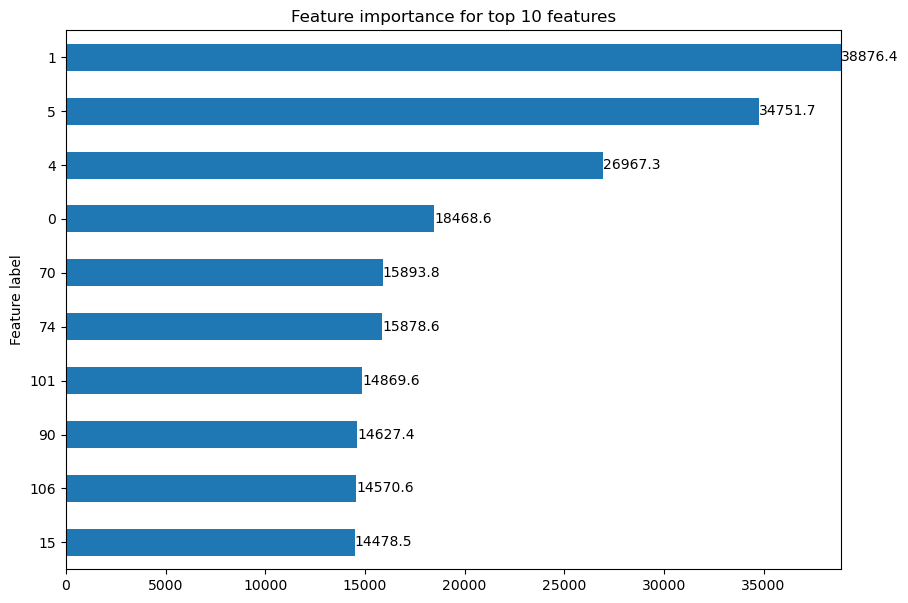

In [258]:
explanation.visualize_feature_importance(top_k=10)

## Fair Models

In [22]:
class FairnessAwareMessagePassingLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(FairnessAwareMessagePassingLayer, self).__init__(aggr='mean')  
        self.lin = nn.Linear(in_channels, out_channels)
        self.a_fair = nn.Parameter(torch.rand(out_channels)) 
        self.sensitive_attr = torch.tensor(user_labels['region'].values, dtype=torch.float) 
        self.bias_correction = nn.Parameter(torch.rand(1))

    def forward(self, x, edge_index):
        # Add self-loops 
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        x = self.lin(x)

        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)
    
    def message(self, x_j, edge_index, size):
        row, col = edge_index
        deg = degree(row, size[0], dtype=x_j.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Compute statistical parity difference for each edge
        group_difference = self.sensitive_attr[row] - self.sensitive_attr[col]
        
        # Adjust messages based on statistical parity
        fairness_adjustment = (1 + self.bias_correction * group_difference.view(-1, 1))

        return fairness_adjustment * norm.view(-1, 1) * x_j

    def update(self, aggr_out):
        return aggr_out

In [23]:
class custom_GCN(torch.nn.Module):
    def __init__(self, data):
        super(custom_GCN, self).__init__()
        self.conv1 = FairnessAwareMessagePassingLayer(data.num_node_features, 16)
        self.conv2 = FairnessAwareMessagePassingLayer(16, 2) # 2 output classes for gender

    def forward(self, x, edge_index, *args, **kwargs):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

### First Fair Model

This model is an instantiation of the `custom_GCN` using the standard cross-entropy loss.

In [70]:
# torch.optim.SGD: Stochastic Gradient Descent optimizer.
# torch.optim.Adam: Adam optimizer.
# torch.optim.Adagrad: Adagrad optimizer.
# torch.optim.Adadelta: Adadelta optimizer.
# torch.optim.RMSprop: RMSprop optimizer.
# torch.optim.AdamW: AdamW optimizer.
# torch.optim.SparseAdam: SparseAdam optimizer.
# torch.optim.LBFGS: L-BFGS optimizer.
# torch.optim.Rprop: Rprop optimizer.

In [28]:
model2 = custom_GCN(data)
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.001)

# Train the model: Custom MP GNN, cross-entropy loss
training(model=model2, data=data, optimizer=optimizer2, epochs=100)

Epoch 0 | Loss: 0.6828877329826355
Epoch 10 | Loss: 0.6807765364646912
Epoch 20 | Loss: 0.6787249445915222
Epoch 30 | Loss: 0.6767349243164062
Epoch 40 | Loss: 0.674805760383606
Epoch 50 | Loss: 0.6729360222816467
Epoch 60 | Loss: 0.6711239814758301
Epoch 70 | Loss: 0.6693678498268127
Epoch 80 | Loss: 0.6676660180091858
Epoch 90 | Loss: 0.6660498976707458


In [29]:
# Test the first FAIR model: CustomGNN, cross-entropy loss
print("Here are the values for the CustomGNN model with the standard cross-entropy loss: ")

metrics_custom_gnn_model_1 = test(model2, data)
print()
print_metrics(metrics_custom_gnn_model_1)

Here are the values for the CustomGNN model with the standard cross-entropy loss: 
Prediction Distribution: {0: 66502, 1: 67}
Privileged Prediction Distribution: {0: 19215, 1: 16}
Unprivileged Prediction Distribution: {0: 47287, 1: 51}
Privileged Positive Prediction Rate: 0.0008319900371134281
Unprivileged Positive Prediction Rate: 0.0010773586109280586

SPD : -0.00025
OAED : -0.02028
EOD : 0.00000


Treatment Equality Difference : 0.00287
SP_Unprivileged : 0.00108
SP_Privileged : 0.00083


OAED_Unprivileged : 0.87270
OAED_Privileged : 0.85243
EOD_Unprivileged : 0.00000


EOD_Privileged : 0.00000
TED_Unprivileged : 0.00854
TED_Privileged : 0.00567


Accuracy : 0.87021


In [72]:
# Test the first FAIR model: CustomGNN, cross-entropy loss
print("Here are the values for the CustomGNN model with the standard cross-entropy loss: ")

metrics_custom_gnn_model_1 = test(model2, data)
print()
print_metrics(metrics_custom_gnn_model_1)

Here are the values for the CustomGNN model with the standard cross-entropy loss: 
Prediction Distribution: {0: 64476, 1: 2093}
Privileged Prediction Distribution: {0: 18688, 1: 543}
Unprivileged Prediction Distribution: {0: 45788, 1: 1550}
Privileged Positive Prediction Rate: 0.0282356608659029
Unprivileged Positive Prediction Rate: 0.03274324908852577

SPD : -0.00451
OAED : -0.01592
EOD : -0.00315


Treatment Equality Difference : 0.06603
SP_Unprivileged : 0.03274
SP_Privileged : 0.02824


OAED_Unprivileged : 0.84729
OAED_Privileged : 0.83137
EOD_Unprivileged : 0.02477


EOD_Privileged : 0.02162
TED_Unprivileged : 0.24060
TED_Privileged : 0.17457


Accuracy : 0.84467


In [ ]:
SPD : -0.00689
OAED : -0.01427
EOD : -0.00439


Treatment Equality Difference : 0.07490
SP_Unprivileged : 0.02759
SP_Privileged : 0.02070


OAED_Unprivileged : 0.85016
OAED_Privileged : 0.83589
EOD_Unprivileged : 0.01573


EOD_Privileged : 0.01134
TED_Unprivileged : 0.20609
TED_Privileged : 0.13118


Accuracy : 0.84926

### Second Fair Model

This model is an instantiation of the `custom_GCN` using the fair cross-entropy loss.

In [34]:
custom_gnn_model_2 = custom_GCN(data)
optimizer_custom_gnn_model_2 = torch.optim.SGD(custom_gnn_model_2.parameters(), lr=0.001)

fairness=True
alpha, beta, gamma, delta = 0.1, 0.1, 0.1, 0.1

# Train the model: Custom MP GNN, FAIR cross-entropy loss
training(model=custom_gnn_model_2, 
         data=data, 
         optimizer=optimizer_custom_gnn_model_2, 
         fairness=fairness, 
         alpha=alpha, 
         beta=beta, 
         gamma=gamma, 
         delta=delta, 
         epochs=100)

Epoch 0 | Loss: 0.40859881043434143
Epoch 10 | Loss: 0.40833157300949097
Epoch 20 | Loss: 0.4080710709095001
Epoch 30 | Loss: 0.4078168570995331
Epoch 40 | Loss: 0.40756848454475403
Epoch 50 | Loss: 0.4073258936405182
Epoch 60 | Loss: 0.40708935260772705
Epoch 70 | Loss: 0.4068576991558075
Epoch 80 | Loss: 0.4066312611103058
Epoch 90 | Loss: 0.40641066431999207


In [35]:
# Test the second FAIR model: CustomGNN, FAIR cross-entropy loss
print("Here are the values for the CustomGNN model with the FAIR standard cross-entropy loss: ")

metrics_custom_gnn_model_2 = test(custom_gnn_model_2, data)
print()
print_metrics(metrics_custom_gnn_model_2)

Here are the values for the CustomGNN model with the FAIR standard cross-entropy loss: 
Prediction Distribution: {0: 65789, 1: 780}
Privileged Prediction Distribution: {0: 19055, 1: 176}
Unprivileged Prediction Distribution: {0: 46734, 1: 604}
Privileged Positive Prediction Rate: 0.009151889942586422
Unprivileged Positive Prediction Rate: 0.012759305536746979

SPD : -0.00361
OAED : -0.01732
EOD : -0.00491


Treatment Equality Difference : 0.03490
SP_Unprivileged : 0.01276
SP_Privileged : 0.00915


OAED_Unprivileged : 0.86736
OAED_Privileged : 0.85003
EOD_Unprivileged : 0.02510


EOD_Privileged : 0.02020
TED_Unprivileged : 0.07794
TED_Privileged : 0.04304


Accuracy : 0.86608


### Third FAIR Model

This model is an instantiation of the `custom_GCN` using the fair cross-entropy loss using ONLY large treatment equality penalty.

In [61]:
custom_gnn_model_3 = custom_GCN(data)
optimizer_custom_gnn_model_3 = torch.optim.SGD(custom_gnn_model_3.parameters(), lr=0.001)

fairness=True
alpha, beta, gamma, delta = 0, 0.4, 0, 0

# Train the model: Custom MP GNN, FAIR cross-entropy loss
training(model=custom_gnn_model_3, 
         data=data, 
         optimizer=optimizer_custom_gnn_model_3, 
         fairness=fairness, 
         alpha=alpha, 
         beta=beta, 
         gamma=gamma, 
         delta=delta, 
         epochs=100)

Epoch 0 | Loss: 0.41925954818725586
Epoch 10 | Loss: 0.41869571805000305
Epoch 20 | Loss: 0.41815832257270813
Epoch 30 | Loss: 0.4176436960697174
Epoch 40 | Loss: 0.41715067625045776
Epoch 50 | Loss: 0.41667720675468445
Epoch 60 | Loss: 0.41622015833854675
Epoch 70 | Loss: 0.4157787263393402
Epoch 80 | Loss: 0.415351003408432
Epoch 90 | Loss: 0.41493579745292664


In [62]:
# Test the third FAIR model: CustomGNN, FAIR cross-entropy loss with LARGE TE penalty
print("Here are the values for the CustomGNN model with the FAIR standard cross-entropy loss with LARGE TE penalty: ")

metrics_custom_gnn_model_3 = test(custom_gnn_model_3, data)
print()
print_metrics(metrics_custom_gnn_model_3)

Here are the values for the CustomGNN model with the FAIR standard cross-entropy loss with LARGE TE penalty: 
Prediction Distribution: {0: 58586, 1: 7983}
Privileged Prediction Distribution: {0: 17186, 1: 2045}
Unprivileged Prediction Distribution: {0: 41400, 1: 5938}
Privileged Positive Prediction Rate: 0.10633872449398041
Unprivileged Positive Prediction Rate: 0.12543833255767822

SPD : -0.01910
OAED : -0.00640
EOD : -0.04346


Treatment Equality Difference : 0.31477
SP_Unprivileged : 0.12544
SP_Privileged : 0.10634


OAED_Unprivileged : 0.79617
OAED_Privileged : 0.78977
EOD_Unprivileged : 0.18946


EOD_Privileged : 0.14600
TED_Unprivileged : 0.99236
TED_Privileged : 0.67759


Accuracy : 0.79473


## Attention-based Message Passing

In this section, the models are trained using a custom attention-based message passing model.  
This custom attention should take the sensitive attribute into consideration when calculating the attention weights.

In [88]:
from torch_geometric.nn import GATConv

### Baseline GAT Models

In [89]:
# GAT class that takes in the data as an input for dimensions of the convolutions
class GAT(torch.nn.Module):
    def __init__(self, x, edge_index):
        super(GAT, self).__init__()
        self.conv1 = GATConv(data.num_node_features, 16)
        self.conv2 = GATConv(16, 2) # 2 output classes for gender

    def forward(self, x , edge_index, *args, **kwargs):
        # x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [107]:
# Instantiate the model, define loss function and optimizer
gat_model = GAT(data.x, data.edge_index)
gat_optimizer = torch.optim.AdamW(gat_model.parameters(), lr=0.01)

In [108]:
training(model=gat_model, data=data, optimizer=gat_optimizer, epochs=50)

Epoch 0 | Loss: 0.5376834273338318
Epoch 10 | Loss: 0.39578431844711304
Epoch 20 | Loss: 0.38350555300712585
Epoch 30 | Loss: 0.37733596563339233
Epoch 40 | Loss: 0.37202683091163635


In [109]:
# Test the first model: GAT, standard data, cross-entropy loss
print("Here are the values for the standard GAT model with the standard cross-entropy loss: ")

metrics_base_gat_model = test(gat_model, data)
print()
print_metrics(metrics_base_gat_model)

Here are the values for the standard GAT model with the standard cross-entropy loss: 
Prediction Distribution: {0: 66130, 1: 439}
Privileged Prediction Distribution: {0: 19080, 1: 151}
Unprivileged Prediction Distribution: {0: 47050, 1: 288}
Privileged Positive Prediction Rate: 0.00785190612077713
Unprivileged Positive Prediction Rate: 0.006083907093852758

SPD : 0.00177
OAED : -0.01961
EOD : 0.00594


Treatment Equality Difference : 0.00049
SP_Unprivileged : 0.00608
SP_Privileged : 0.00785


OAED_Unprivileged : 0.87344
OAED_Privileged : 0.85383
EOD_Unprivileged : 0.02276


EOD_Privileged : 0.02870
TED_Unprivileged : 0.02603
TED_Privileged : 0.02554


Accuracy : 0.87141


### FairMP GAT Models

In [63]:
import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops

class Attention_FairMessagePassing(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(Attention_FairMessagePassing, self).__init__(aggr='mean')
        self.lin = nn.Linear(in_channels, out_channels)
        self.att = nn.Linear(out_channels, 1)
        self.sensitive_attr = torch.tensor(user_labels['region'].values, dtype=torch.float)
        self.bias_correction = nn.Parameter(torch.rand(1))

    def forward(self, x, edge_index):
        # Add self-loops
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        x = self.lin(x)
        x = self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)

        return x

    def message(self, x_i, x_j):
        # Calculate attention weights
        alpha = self.att(torch.abs(x_i - x_j))
        alpha = torch.exp(alpha) / (torch.exp(alpha).sum(dim=1, keepdim=True) + self.bias_correction)

        # Apply attention weights to messages
        return x_j * alpha

    def update(self, aggr_out):
        return aggr_out


In [64]:
# GAT class that takes in the data as an input for dimensions of the convolutions
class CustomGAT(torch.nn.Module):
    def __init__(self, x, edge_index):
        super(CustomGAT, self).__init__()
        self.conv1 = Attention_FairMessagePassing(data.num_node_features, 16)
        self.conv2 = Attention_FairMessagePassing(16, 2) # 2 output classes for gender

    def forward(self, x , edge_index, *args, **kwargs):
        # x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

#### First Fair GAT

In [104]:
# Instantiate the model, define loss function and optimizer
custom_gat_model = CustomGAT(data.x, data.edge_index)
custom_gat_optimizer = torch.optim.AdamW(custom_gat_model.parameters(), lr=0.01)

In [105]:
training(model=custom_gat_model, data=data, optimizer=custom_gat_optimizer, epochs=50)

Epoch 0 | Loss: 0.45256906747817993
Epoch 10 | Loss: 0.39204564690589905
Epoch 20 | Loss: 0.38255640864372253
Epoch 30 | Loss: 0.37586042284965515
Epoch 40 | Loss: 0.3703364133834839


In [106]:
# Test the first model: CustomGAT, standard data, cross-entropy loss
print("Here are the values for the CustomGAT model with the standard cross-entropy loss: ")

metrics_custom_gat_model = test(custom_gat_model, data)
print()
print_metrics(metrics_custom_gat_model)

Here are the values for the CustomGAT model with the standard cross-entropy loss: 
Prediction Distribution: {0: 66139, 1: 430}
Privileged Prediction Distribution: {0: 19111, 1: 120}
Unprivileged Prediction Distribution: {0: 47028, 1: 310}
Privileged Positive Prediction Rate: 0.006239925045520067
Unprivileged Positive Prediction Rate: 0.006548650097101927

SPD : -0.00031
OAED : -0.01993
EOD : -0.00234


Treatment Equality Difference : 0.00724
SP_Unprivileged : 0.00655
SP_Privileged : 0.00624


OAED_Unprivileged : 0.87319
OAED_Privileged : 0.85326
EOD_Unprivileged : 0.02360


EOD_Privileged : 0.02126
TED_Unprivileged : 0.02897
TED_Privileged : 0.02172


Accuracy : 0.87186


In [ ]:
# SPD : 0.00177
# OAED : -0.01961
# EOD : 0.00594


# Treatment Equality Difference : 0.00049
# SP_Unprivileged : 0.00608
# SP_Privileged : 0.00785


# OAED_Unprivileged : 0.87344
# OAED_Privileged : 0.85383
# EOD_Unprivileged : 0.02276


# EOD_Privileged : 0.02870
# TED_Unprivileged : 0.02603
# TED_Privileged : 0.02554


# Accuracy : 0.87141

In [ ]:
# SPD : 0.00009
# OAED : -0.02074
# EOD : -0.00063


# Treatment Equality Difference : -0.00081
# SP_Unprivileged : 0.00038
# SP_Privileged : 0.00047


# OAED_Unprivileged : 0.87374
# OAED_Privileged : 0.85300
# EOD_Unprivileged : 0.00134


# EOD_Privileged : 0.00071
# TED_Unprivileged : 0.00168
# TED_Privileged : 0.00248


# Accuracy : 0.87171

#### Second Fair GAT

In [65]:
# Instantiate the model, define loss function and optimizer
custom_gat_model_2 = CustomGAT(data.x, data.edge_index)
custom_gat_optimizer_2 = torch.optim.AdamW(custom_gat_model_2.parameters(), lr=0.01)

In [66]:
training(model=custom_gat_model_2, data=data, optimizer=custom_gat_optimizer_2, fairness=True, beta=0.1, epochs=50)

Epoch 0 | Loss: 0.5545613169670105
Epoch 10 | Loss: 0.3832014501094818
Epoch 20 | Loss: 0.35803094506263733
Epoch 30 | Loss: 0.3484097123146057
Epoch 40 | Loss: 0.34348684549331665


In [67]:
# Test the second model: CustomGAT, FAIR cross-entropy loss
print("Here are the values for the CustomGAT model with the FAIR cross-entropy loss: ")

metrics_custom_gat_model_2 = test(custom_gat_model_2, data)

print_metrics(metrics_custom_gat_model_2)

Here are the values for the CustomGAT model with the FAIR cross-entropy loss: 
Prediction Distribution: {0: 66282, 1: 287}
Privileged Prediction Distribution: {0: 19156, 1: 75}
Unprivileged Prediction Distribution: {0: 47126, 1: 212}
Privileged Positive Prediction Rate: 0.003899953095242381
Unprivileged Positive Prediction Rate: 0.004478431772440672
SPD : -0.00058
OAED : -0.01979
EOD : -0.00134


Treatment Equality Difference : 0.00769
SP_Unprivileged : 0.00448
SP_Privileged : 0.00390


OAED_Unprivileged : 0.87268
OAED_Privileged : 0.85289
EOD_Unprivileged : 0.01339


EOD_Privileged : 0.01205
TED_Unprivileged : 0.02239
TED_Privileged : 0.01471


Accuracy : 0.87149


In [113]:
# Test the second model: CustomGAT, FAIR cross-entropy loss
print("Here are the values for the CustomGAT model with the FAIR cross-entropy loss: ")

metrics_custom_gat_model_2 = test(custom_gat_model_2, data)

print_metrics(metrics_custom_gat_model_2)

Here are the values for the CustomGAT model with the FAIR cross-entropy loss: 
Prediction Distribution: {0: 66542, 1: 27}
Privileged Prediction Distribution: {0: 19222, 1: 9}
Unprivileged Prediction Distribution: {0: 47320, 1: 18}
Privileged Positive Prediction Rate: 0.0004679943958763033
Unprivileged Positive Prediction Rate: 0.0003802441933657974
SPD : 0.00009
OAED : -0.02074
EOD : -0.00063


Treatment Equality Difference : -0.00081
SP_Unprivileged : 0.00038
SP_Privileged : 0.00047


OAED_Unprivileged : 0.87374
OAED_Privileged : 0.85300
EOD_Unprivileged : 0.00134


EOD_Privileged : 0.00071
TED_Unprivileged : 0.00168
TED_Privileged : 0.00248


Accuracy : 0.87171
